In [1]:
import os
import multiprocessing
from functools import partial

import faiss
import numpy as np
import torch

from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.res = faiss.StandardGpuResources()
#         self.gpu_index = faiss.index_cpu_to_all_gpus(  # build the index
#             self.index
#         )
        self.gpu_index = faiss.index_cpu_to_gpu(
            self.res,
            0,
            self.index
        )
        self.y = y

    def predict(self, X):
        distances, indices = self.gpu_index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return indices, distances

In [3]:
# basic params

k = 500
n = 500
N = 500000
r = 1.0
max_norm = 0.1

k_neighbors = 50

# making the sphere

points_k = np.random.normal(0, 1, size=(N//2, k))
points_k = r * (points_k / np.linalg.norm(points_k, ord=2, axis=1).reshape(-1, 1))

points_n = np.zeros((N, n))
points_n[:N//2, :k] = points_k

knn = FaissKNeighbors(k=k_neighbors + 1)
knn.fit(points_n[:N//2], y=np.zeros(N//2, dtype=np.int64))

# nbhrs, dists = knn.predict()
    
var_thresh = 0.99 # threshold of explained variance for selecting normal directions


In [4]:
indices, dists = knn.predict(points_n)



In [5]:
%%time
off_mfld_pts = np.zeros((N // 2, n))
off_mfld_dists = np.zeros(N//2)

# def make_off_mfld_eg(idx, points_n, indices):
    
def make_off_mfld_eg(idx):
    
    global points_n
    global indices
    global off_mfld_pts
    global off_mfld_dists
    
    on_mfld_pt = points_n[idx]
    nbhr_indices = indices[idx]
    nbhr_indices = nbhr_indices[nbhr_indices != idx]
    nbhrs = points_n[nbhr_indices]
    nbhr_local_coords = nbhrs - on_mfld_pt
    
    pca = PCA()
    pca.fit(nbhr_local_coords)
    expl_var = pca.explained_variance_ratio_
    cum_expl_var = np.cumsum(expl_var)
    tmp = np.where(cum_expl_var > var_thresh)[0][0] + 1
    normal_dirs = pca.components_[tmp:] # picking components that explain (1 - var_thresh)
    
    rdm_coeffs = np.random.normal(0, 1, size=normal_dirs.shape[0])
    off_mfld_pt = np.sum(rdm_coeffs.reshape(-1, 1) * normal_dirs, axis=0)
    rdm_norm = np.random.uniform(0, max_norm)
    off_mfld_pt = off_mfld_pt * (rdm_norm / np.linalg.norm(off_mfld_pt))
    off_mfld_pt += on_mfld_pt
    
#     off_mfld_pts[idx] = off_mfld_pt
#     off_mfld_dists[idx] = rdm_norm
    
    return (idx, off_mfld_pt, rdm_norm)

# make_off_mfld_eg_partial = partial(make_off_mfld_eg, points_n=points_n, indices=indices)

with multiprocessing.Pool(processes=8) as pool:
#     results = pool.map(make_off_mfld_eg_partial, range(N//2))
    results = pool.map(make_off_mfld_eg, range(N//2))

for i in range(len(results)):
    off_mfld_pts[i] = results[i][1]
    off_mfld_dists[i] = results[i][2]
    

    
    
    
# for idx in tqdm(range(N // 2)):
#     on_mfld_pt = points_n[idx]
#     nbhr_indices = indices[idx]
#     nbhr_indices = nbhr_indices[nbhr_indices != idx]
#     nbhrs = points_n[nbhr_indices]
#     nbhr_local_coords = nbhrs - on_mfld_pt
    
#     pca = PCA()
#     pca.fit(nbhr_local_coords)
#     expl_var = pca.explained_variance_ratio_
#     cum_expl_var = np.cumsum(expl_var)
#     tmp = np.where(cum_expl_var > var_thresh)[0][0] + 1
#     normal_dirs = pca.components_[tmp:] # picking components that explain (1 - var_thresh)
    
#     rdm_coeffs = np.random.normal(0, 1, size=normal_dirs.shape[0])
#     off_mfld_pt = np.sum(rdm_coeffs.reshape(-1, 1) * normal_dirs, axis=0)
#     rdm_norm = np.random.uniform(0, max_norm)
#     off_mfld_pt = off_mfld_pt * (rdm_norm / np.linalg.norm(off_mfld_pt))
#     off_mfld_dists[idx] = rdm_norm
#     off_mfld_pt += on_mfld_pt
#     off_mfld_pts[idx] = off_mfld_pt
#     break

    
    

CPU times: user 2.24 s, sys: 2.29 s, total: 4.53 s
Wall time: 20min 22s


In [1]:
pca.explained_variance_ratio_
cum_expl_var
tmp

NameError: name 'pca' is not defined

In [7]:
off_mfld_pt, on_mfld_pt, rdm_norm, np.linalg.norm(on_mfld_pt - off_mfld_pt)

(array([1.06755357, 0.14781959]),
 array([0.99368677, 0.11219004]),
 0.08201078848791471,
 0.0820107884879148)

In [55]:

pca = PCA()
pca.fit(points_n[indices[5]] - points_n[5])


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [56]:
points_n[indices[5]]

array([[ 0.29410196, -0.95577405,  0.        ],
       [ 0.29383026, -0.95585761,  0.        ],
       [ 0.29392775, -0.95582764,  0.        ],
       [ 0.2937978 , -0.95586759,  0.        ],
       [ 0.2939352 , -0.95582535,  0.        ],
       [ 0.29397653, -0.95581264,  0.        ],
       [ 0.29392409, -0.95582877,  0.        ],
       [ 0.29365255, -0.95591223,  0.        ],
       [ 0.2938732 , -0.95584441,  0.        ],
       [ 0.29385505, -0.95584999,  0.        ],
       [ 0.29366476, -0.95590847,  0.        ]])

In [10]:
dists[2], indices[2]

(array([0.       , 1.6022702, 1.6134851, 1.6229258, 1.6373756, 1.6415846,
        1.6428125, 1.648608 , 1.6487112, 1.6503485, 1.6561202, 1.6567991,
        1.6580863, 1.6589345, 1.6626413, 1.662984 , 1.6640503, 1.6672132,
        1.6672343, 1.6679883, 1.6680709, 1.6692023, 1.6695664, 1.6707433,
        1.674704 , 1.6749394, 1.6749641, 1.6751659, 1.6763891, 1.6769282,
        1.6776607, 1.6779829, 1.678489 , 1.6791576, 1.6792035, 1.6792777,
        1.679966 , 1.6799793, 1.6802373, 1.68033  , 1.6806178, 1.6809877,
        1.6818882, 1.6820472, 1.6824007, 1.6843482, 1.6853373, 1.6854991,
        1.6855222, 1.6858478, 1.6863543], dtype=float32),
 array([     2,  72811,  57145, 194078,  39554, 192545,  97083, 204859,
        224904, 179416, 127668, 107694, 106971, 147182, 215830, 139678,
         92710,  61649,  72884, 116038,  64239, 154403,  45977,  43581,
        214902,  55840,  87904, 142881,  38294,  76620,  58143, 241123,
         32197,  24398,  97152,  89777, 237524,  37559, 178059

In [57]:
pca.explained_variance_ratio_

array([9.99999993e-01, 6.82070253e-09, 0.00000000e+00])

In [58]:
x = points_n[indices[5]][0] - points_n[5]
x /= np.linalg.norm(x)
np.dot(x, pca.components_[0])

0.9999999933976171

In [62]:
pca.components_

array([[ 0.95584948,  0.29385673,  0.        ],
       [-0.29385673,  0.95584948,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [60]:
np.dot(points_n[indices[5]][0] - points_n[5], pca.components_[1])

3.255709951172038e-08

In [61]:
np.dot(points_n[indices[5]][0] - points_n[5], pca.components_[2])

0.0

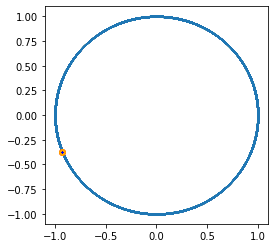

In [6]:
plt.figure(figsize=(4, 4))
# plt.scatter(off_mfld_pts[:, 0], off_mfld_pts[:, 1], s=0.01, alpha=0.5)
plt.scatter(points_n[:N//2, 0], points_n[:N//2, 1], s=0.01, alpha=0.5)
idx = 5
plt.scatter(off_mfld_pts[idx, 0], off_mfld_pts[idx, 1], color="red")
plt.scatter(points_n[idx, 0], points_n[idx, 1], color="orange")

plt.scatter(points_n[indices[idx], 0], points_n[indices[idx], 1], s=0.1, c="blue")
# colors = ["orange", "green"]
# labels = np.round(pca.explained_variance_ratio_, 3)
# arrows = list()
# for i in range(pca.components_.shape[0]):
#     arr = plt.arrow(points_n[idx, 0], points_n[idx, 1], pca.components_[i, 0], pca.components_[i, 1], label=str(labels[i]), color=colors[i])
#     arrows.append(arr)
# plt.legend(arrows, [str(i) for i in labels])

In [19]:
np.dot(off_mfld_pt - on_mfld_pt, nbhr_local_coords[2])

-1.1622371549394984e-06

In [6]:
rdm_idx = np.random.choice(np.arange(N//2), 1000, replace=False)
min_true_dists = np.zeros(rdm_idx.shape[0])
dev_frm_on_mfld = np.zeros(rdm_idx.shape[0])
for idx in tqdm(range(rdm_idx.shape[0])):
    true_off_mfld_dists = np.linalg.norm(off_mfld_pts[rdm_idx[idx]] - points_n[:N//2,:], ord=2, axis=1)
    min_true_dist = np.min(true_off_mfld_dists)
    min_true_dists[idx] = min_true_dist
    min_true_dist_idx = np.argmin(true_off_mfld_dists)
    dev_frm_on_mfld[idx] = np.linalg.norm(points_n[min_true_dist_idx] - points_n[rdm_idx[idx]])
    
    

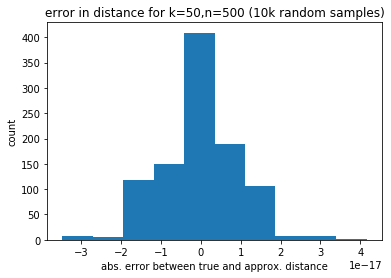

In [7]:
plt.hist(min_true_dists - off_mfld_dists[rdm_idx])
plt.xlabel("abs. error between true and approx. distance")
plt.ylabel("count")
plt.title("error in distance for k={},n={} (10k random samples)".format(k, n))
plt.show()

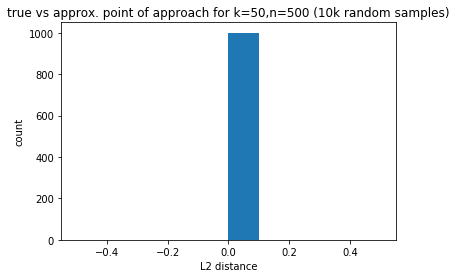

In [8]:
plt.hist(dev_frm_on_mfld)
plt.xlabel("L2 distance")
plt.ylabel("count")
plt.title("true vs approx. point of approach for k={},n={} (10k random samples)".format(k, n))
plt.show()

In [9]:
max(dev_frm_on_mfld)

0.0

In [22]:
np.argmin(np.linalg.norm(off_mfld_pts[0] - points_n[:N//2,:], ord=2, axis=1)), \
np.min(np.linalg.norm(off_mfld_pts[0] - points_n[:N//2,:], ord=2, axis=1))

(183969, 0.03786256990766121)

In [23]:
np.linalg.norm(off_mfld_pts[0] - points_n[:N//2,:], ord=2, axis=1)

array([0.04658179, 1.71577159, 1.38675184, ..., 1.44299178, 1.79183774,
       0.5097944 ])

In [24]:
np.linalg.norm(points_n[141727] - points_n[0])

0.04689816673859133

In [25]:
off_mfld_dists[0]

0.04658178909987768

In [49]:
tmp = np.random.normal(0, 1, size=(50, 500))
tmp_pca = PCA()
tmp_pca.fit(tmp)


array([[ 0.02824323,  0.00235902,  0.01950889, ..., -0.03805938,
        -0.01381973, -0.00307733],
       [ 0.00770392, -0.07358862, -0.048848  , ..., -0.02004137,
         0.00309767,  0.07561612],
       [ 0.03270278,  0.06981782, -0.07356335, ...,  0.00973231,
        -0.02722055,  0.02475773],
       ...,
       [ 0.08825714, -0.0063782 ,  0.04923243, ..., -0.05390884,
         0.00651722,  0.07160276],
       [-0.00234416,  0.00937723,  0.0077863 , ..., -0.04157526,
        -0.01050973,  0.02776842],
       [-0.24057345,  0.06831079, -0.11079424, ...,  0.0103417 ,
        -0.02203047,  0.01865837]])

In [50]:
tmp_pca.components_.shape

(50, 500)

In [51]:
tmp_pca.explained_variance_ratio_

array([3.29956181e-02, 3.25079828e-02, 3.22565262e-02, 3.11799404e-02,
       3.06632475e-02, 3.01812442e-02, 2.88631601e-02, 2.86225564e-02,
       2.82011201e-02, 2.76663391e-02, 2.64148828e-02, 2.56271934e-02,
       2.49715904e-02, 2.47920407e-02, 2.41121771e-02, 2.37524494e-02,
       2.32314183e-02, 2.24774617e-02, 2.22923907e-02, 2.18679557e-02,
       2.12356529e-02, 2.08215778e-02, 2.02357207e-02, 1.99912026e-02,
       1.97705482e-02, 1.93732695e-02, 1.90554016e-02, 1.85600662e-02,
       1.84403614e-02, 1.76812580e-02, 1.73093909e-02, 1.67078570e-02,
       1.61468635e-02, 1.59964393e-02, 1.58146529e-02, 1.52381204e-02,
       1.49448302e-02, 1.45239901e-02, 1.41972889e-02, 1.35859178e-02,
       1.34444766e-02, 1.30615833e-02, 1.26759973e-02, 1.23808206e-02,
       1.22690058e-02, 1.18452026e-02, 1.14014961e-02, 1.09030661e-02,
       9.71064657e-03, 6.50614319e-33])